In [1]:
import pandas as pd
import geopandas as gpd
import sys
import matplotlib.pyplot as plt 
import seaborn as sns
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy.plot as ep
import numpy as np
from rasterstats import zonal_stats
from shapely import wkt
import seaborn as sns
dir_path = './data/raw/'

In [2]:
%%time
# Building footprints
buildings = gpd.read_file('./data/raw/building_footprints_google_w_districts.geojson')
# to lowercase
buildings.District = buildings.District.str.lower()
buildings['origin_origin_id'] = buildings.origin +'_'+buildings.origin_id # Identifier
buildings_geom = buildings[['origin_origin_id','geometry']].copy()

# districts
district_boundaries = gpd.read_file(dir_path+'District_Boundaries.geojson')

# meter data
meter_data = pd.read_pickle('./data/processed/reliabilty_cons_w_conn_days_22_11_22_12am.pck')

# schools
schools = gpd.read_file(dir_path+'Education_Facilities.geojson')
# health centers
health_centers = gpd.read_file(dir_path+'Health_Facilities.geojson')
# trade centres
trade_centres =  gpd.read_file(dir_path+'Trade_centers.geojson')
# coffee centers
coffee_centres =  gpd.read_file(dir_path+'Coffee_Washing_Stations.geojson')
# trade centers
tourism_centres =  gpd.read_file(dir_path+'Tourism_POI.geojson')
# industry parks
industry_centres =  gpd.read_file(dir_path+'Industrial_parks.geojson')
# district offices
district_offices =  gpd.read_file(dir_path+'District_offices.geojson')
# religious centres
religious_centres =  gpd.read_file(dir_path+'Religious_Facilities.geojson')
# sports centers
sports_centres =  gpd.read_file(dir_path+'Sports.geojson')
# major towns
major_towns = pd.read_csv(dir_path+'rwanda_major_towns.csv')
major_towns['geometry'] = major_towns['geometry'].apply(wkt.loads)
major_towns = gpd.GeoDataFrame(major_towns, crs='epsg:4326')
# bus stations
bus_stations =  gpd.read_file(dir_path+'Bus_stations.geojson')
# landmark
landmark =  gpd.read_file(dir_path+'national_roads_and_landmarks/Land_Mark.shp')
# district roads
district_road =  gpd.read_file(dir_path+'national_roads_and_landmarks/National_District1_Road.shp')
# National Paved roads
national_paved_road =  gpd.read_file(dir_path+'national_roads_and_landmarks/National_Road_Paved.shp')
# National unPaved roads
national_unpaved_road =  gpd.read_file(dir_path+'national_roads_and_landmarks/National_Road_Unpaved.shp')
# all country road network
road_netwk =  gpd.read_file(dir_path+'Road_network.geojson')
# north province
province =  gpd.read_file(dir_path+'Province_Boundaries.geojson')



# Use projected CRS
crs = 'epsg:32735'
buildings_geom_utm_RW = buildings_geom.to_crs(crs)
schools = schools.to_crs(crs)
health_centers = health_centers.to_crs(crs)
trade_centres = trade_centres.to_crs(crs)
coffee_centres = coffee_centres.to_crs(crs)
tourism_centres = tourism_centres.to_crs(crs)
industry_centres = industry_centres.to_crs(crs)
district_offices = district_offices.to_crs(crs)
religious_centres = religious_centres.to_crs(crs)
sports_centres = sports_centres.to_crs(crs)
major_towns = major_towns.to_crs(crs)
bus_stations = bus_stations.to_crs(crs)
landmark = landmark.to_crs(crs)
district_road = district_road.to_crs(crs)
national_paved_road = national_paved_road.to_crs(crs)
national_unpaved_road = national_unpaved_road.to_crs(crs)
road_netwk = road_netwk.to_crs(crs)
province = province.to_crs(crs)
district_boundaries = district_boundaries.to_crs(crs)



CPU times: user 11min 46s, sys: 17.8 s, total: 12min 4s
Wall time: 12min 6s


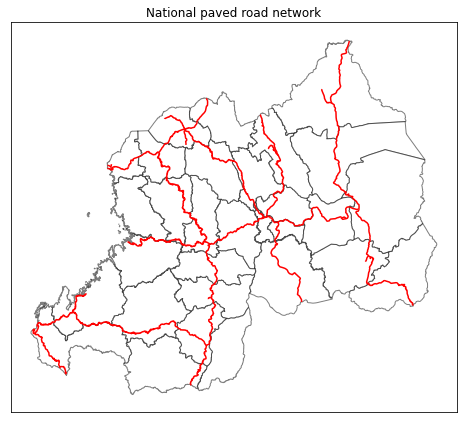

In [18]:
# Main national roads
fig, ax = plt.subplots(1, figsize = (8, 8))
district_boundaries.plot(ax=ax, color='white',edgecolor='black', alpha=0.5)
national_paved_road.plot(ax=ax,color='red')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('National paved road network')
plt.show()

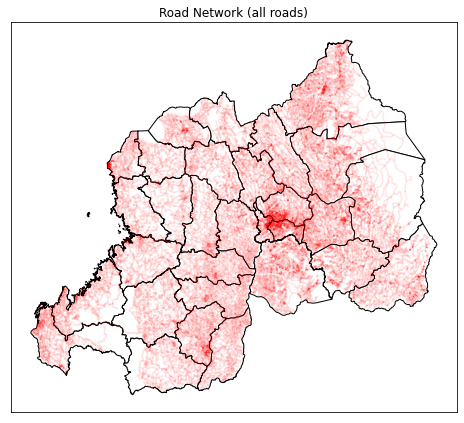

CPU times: user 7.75 s, sys: 1.99 ms, total: 7.75 s
Wall time: 7.76 s


In [19]:
%%time
# All roads
fig, ax = plt.subplots(1, figsize = (8, 8))
district_boundaries.plot(ax=ax, color='white',edgecolor='black')
road_netwk.plot(ax=ax,color='red', alpha=0.1)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Road Network (all roads)')
plt.show()

## Match meter GPS to nearest building footprint

In [3]:
%%time

meter_building_dist = 60 # max distance between meter and building
# Match building footprints to nearest meter locations
meter_data_w_bf = gpd.sjoin_nearest(meter_data, buildings_geom_utm_RW,
                                    how='left', distance_col="meter_building_distance", max_distance = meter_building_dist).drop('index_right',axis=1)
meter_data_w_bf_w_consumption = meter_data_w_bf[meter_data_w_bf.annual_consumption_2019.notna()] # remove buildings with no recorded consumption
buildings_w_consumption_lst = meter_data_w_bf_w_consumption.origin_origin_id.unique().tolist()
buildings_geom_w_consumption = buildings_geom_utm_RW[buildings_geom_utm_RW.origin_origin_id.isin(buildings_w_consumption_lst)].copy() # buildings with consumption

CPU times: user 24.9 s, sys: 1 s, total: 25.9 s
Wall time: 25.9 s


### Adding proximity to socio-Economic  infrastructure features

In [92]:
%%time
# add school distances
buildings_features = gpd.sjoin_nearest(buildings_geom_w_consumption,
                                                schools[['geometry']], how='left',
                                       distance_col="school_building_dist").drop('index_right',axis=1).rename(columns={'code_vill_':'village_id'})
# add health centers distances
buildings_features = gpd.sjoin_nearest(buildings_features,
                                                health_centers[['geometry']], how='left', distance_col="health_building_dist").drop('index_right',axis=1)
# add trade centers distances
buildings_features = gpd.sjoin_nearest(buildings_features,
                                                trade_centres[['geometry']], how='left', distance_col="trade_building_dist").drop('index_right',axis=1)

# add coffee centers distances
buildings_features = gpd.sjoin_nearest(buildings_features,
                                                coffee_centres[['geometry']], how='left', distance_col="coffee_building_dist").drop('index_right',axis=1)
# add tourism centers distances
buildings_features = gpd.sjoin_nearest(buildings_features,
                                                tourism_centres[['geometry']], how='left', distance_col="tourism_building_dist").drop('index_right',axis=1)

# add industry parks  distances
buildings_features = gpd.sjoin_nearest(buildings_features,
                                                industry_centres[['geometry']], how='left', distance_col="industrypark_building_dist").drop('index_right',axis=1)
# add District_offices  distances
buildings_features = gpd.sjoin_nearest(buildings_features,
                                                industry_centres[['geometry']], how='left', distance_col="District_offices_building_dist").drop('index_right',axis=1)
# add religious_centres distances
buildings_features = gpd.sjoin_nearest(buildings_features,
                                                religious_centres[['geometry']], how='left', distance_col="religious_centres_building_dist").drop('index_right',axis=1)
# add Sports centres distances
buildings_features = gpd.sjoin_nearest(buildings_features,
                                                sports_centres[['geometry']], how='left', distance_col="sports_centres_building_dist").drop('index_right',axis=1)
# add major town distances
buildings_features = gpd.sjoin_nearest(buildings_features,
                                                major_towns[['geometry']], how='left', distance_col="major_towns_building_dist").drop('index_right',axis=1)
# add bus stations distances
buildings_features = gpd.sjoin_nearest(buildings_features,
                                                bus_stations[['geometry']], how='left', distance_col="bus_stations_building_dist").drop('index_right',axis=1)
# add landmark distances
buildings_features = gpd.sjoin_nearest(buildings_features,
                                                landmark[['geometry']], how='left', distance_col="landmark_building_dist").drop('index_right',axis=1)


# add National Paved roads distances
buildings_features = gpd.sjoin_nearest(buildings_features,
                                                national_paved_road[['geometry']], how='left', distance_col="national_paved_road_building_dist").drop('index_right',axis=1)

# add National unPaved roads distances
buildings_features = gpd.sjoin_nearest(buildings_features,
                                                national_unpaved_road[['geometry']], how='left', distance_col="national_unpaved_road_building_dist").drop('index_right',axis=1)

# country wide road network
buildings_features = gpd.sjoin_nearest(buildings_features,
                                                road_netwk[['globalid','class','status','settlement','geometry']], 
                                       how='left', distance_col="road_netwk_building_dist").drop('index_right',axis=1)



## Add Raster features

In [4]:
%%time




## Import raster features
# import landcover files
df_lc_2015 = pd.read_pickle(dir_path+'lc_2015.pck')
df_lc_2010 = pd.read_pickle(dir_path+'lc_2010.pck')
df_lc_2000 = pd.read_pickle(dir_path+'lc_2000.pck')
df_lc_1990 = pd.read_pickle(dir_path+'lc_1990.pck')
# import population files
df_popn_2005 = pd.read_pickle(dir_path+'village_mean_popn_2005.pck')
df_popn_2015 = pd.read_pickle(dir_path+'village_mean_popn_2015.pck')
# import elevation file
df_elev = pd.read_pickle(dir_path+'village_mean_elevation.pck')
# import AWI
df_AWI_2016 = pd.read_pickle(dir_path+'AWI_2016.pck')
df_AWI_2017 = pd.read_pickle(dir_path+'AWI_2017.pck')
df_AWI_2018 = pd.read_pickle(dir_path+'AWI_2018.pck')
df_AWI_2019 = pd.read_pickle(dir_path+'AWI_2019.pck')
# import spending
df_spending_2016 = pd.read_pickle(dir_path+'spending_2016.pck')
df_spending_2017 = pd.read_pickle(dir_path+'spending_2017.pck')
df_spending_2018 = pd.read_pickle(dir_path+'spending_2018.pck')
df_spending_2019 = pd.read_pickle(dir_path+'spending_2019.pck')

CPU times: user 26.6 ms, sys: 3.08 ms, total: 29.7 ms
Wall time: 452 ms


In [5]:
%%time
# load building features
building_features_all = pd.read_pickle('./data/processed/buildings_features_22_11_22_4pm.pck') # load building features from vectors
building_features = building_features_all[building_features_all.origin_origin_id.isin(buildings_w_consumption_lst)].copy() # keep buildings with consumption

# merge vector and raster features

# LULC
building_features = building_features.merge(df_lc_2015[['village_id','majority']], how='left',on='village_id').rename(columns={'majority':'majority_2015'})
building_features = building_features.merge(df_lc_2010[['village_id','majority']], how='left',on='village_id').rename(columns={'majority':'majority_2010'})
building_features = building_features.merge(df_lc_2000[['village_id','majority']], how='left',on='village_id').rename(columns={'majority':'majority_2000'})
building_features = building_features.merge(df_lc_1990[['village_id','majority']], how='left',on='village_id').rename(columns={'majority':'majority_1990'})
# Popn
building_features = building_features.merge(df_popn_2005[['village_id','mean_popn']], how='left',on='village_id').rename(columns={'mean_popn':'mean_popn_2005'})
building_features = building_features.merge(df_popn_2015[['village_id','mean_popn']], how='left',on='village_id').rename(columns={'mean_popn':'mean_popn_2015'})
building_features = building_features.merge(df_elev[['village_id','mean_elevation']], how='left',on='village_id')
# AWI
building_features = building_features.merge(df_AWI_2016[['village_id','mean_AWI']], how='left',on='village_id').rename(columns={'mean_AWI':'mean_AWI_2016'})
building_features = building_features.merge(df_AWI_2017[['village_id','mean_AWI']], how='left',on='village_id').rename(columns={'mean_AWI':'mean_AWI_2017'})
building_features = building_features.merge(df_AWI_2018[['village_id','mean_AWI']], how='left',on='village_id').rename(columns={'mean_AWI':'mean_AWI_2018'})
building_features = building_features.merge(df_AWI_2019[['village_id','mean_AWI']], how='left',on='village_id').rename(columns={'mean_AWI':'mean_AWI_2019'})
# spending
building_features = building_features.merge(df_spending_2016[['village_id','mean_spending']], how='left',on='village_id').rename(columns={'mean_spending':'mean_spending_2016'})
building_features = building_features.merge(df_spending_2017[['village_id','mean_spending']], how='left',on='village_id').rename(columns={'mean_spending':'mean_spending_2017'})
building_features = building_features.merge(df_spending_2018[['village_id','mean_spending']], how='left',on='village_id').rename(columns={'mean_spending':'mean_spending_2018'})
building_features = building_features.merge(df_spending_2019[['village_id','mean_spending']], how='left',on='village_id').rename(columns={'mean_spending':'mean_spending_2019'})

# village density
    # all buildings
village_density = building_features_all.groupby(['village_id'])['origin_origin_id'].count().reset_index().rename(columns={'origin_origin_id':'village_density_all'})
building_features = building_features.merge(village_density, how='left',on='village_id')
    # buildings with consumption
village_density = building_features.groupby(['village_id'])['origin_origin_id'].count().reset_index().rename(columns={'origin_origin_id':'village_density_only_consumers'})
building_features = building_features.merge(village_density, how='left',on='village_id')    
# adding coordinates
building_features = building_features.merge(buildings[['origin_origin_id','longitude','latitude']], how='left', on='origin_origin_id')

CPU times: user 18.2 s, sys: 2.97 s, total: 21.2 s
Wall time: 21.5 s


In [11]:
%%time


def filter_categories(list_items):
    '''
    function to select unique categories for each building
    If building has one non-residential categorize it as non residential
    '''
    item = ''
    if len(list_items)>1:
        
        for item in list_items:
            if item=='Non Residential':
                item = 'Non Residential'
            else:
                item= 'Residential'
        return item
    else:
        return list_items[0] 

#unique categories for each building
meter_data_cats = meter_data_w_bf_w_consumption.groupby(['origin_origin_id'])['eguide_categories'].unique().reset_index()
meter_data_cats['eguide_categories'] = meter_data_cats['eguide_categories'].apply(lambda x: filter_categories(x))

    
# Building 2019 total consumption
buiding_kWh = meter_data_w_bf_w_consumption.groupby(['origin_origin_id'])['annual_consumption_2019'].sum(min_count=1).reset_index()
# Building days since connection, saifi, saidi
meter_data_features =meter_data_w_bf_w_consumption.groupby(['origin_origin_id'])[['days_since_connection','saifi_2020','saifi_2019','saifi_2018','saifi_2017','saifi_2016',
                                                                                 'saidi_2020','saidi_2019','saidi_2018','saidi_2017','saidi_2016']].max().reset_index()

# merge meter features
meter_data_features = meter_data_features.merge(buiding_kWh, how='left',on='origin_origin_id')
meter_data_features = meter_data_features.merge(meter_data_cats, how='left',on='origin_origin_id')

# merge meter and building features
data = building_features.merge(meter_data_features, how='inner', on='origin_origin_id')
data = data[data.annual_consumption_2019.notna()].drop('globalid', axis=1)
data['eguide_categories']=data['eguide_categories'].apply(lambda x: 'Non Residential' if x=='other' else x) # convert 'other' to 'Non Residential'

CPU times: user 20.4 s, sys: 202 ms, total: 20.6 s
Wall time: 20.6 s


In [15]:
# village boundaries
village_boundaries = gpd.read_file('./data/raw/Villages_boundaries.geojson').rename(columns={'code_vill_':'village_id'})
village_boundaries['district'] = village_boundaries['district'].str.lower()

# merge
data = data.merge(village_boundaries[['village_id','district','province']], how='left',on='village_id')

# remove NaNs
columns_w_nans_dist = ['mean_AWI_2019','mean_AWI_2018','mean_AWI_2017','mean_AWI_2016','mean_spending_2019','mean_spending_2018','mean_spending_2017','mean_spending_2016',
                  'saifi_2020','saifi_2019','saifi_2018','saifi_2017','saifi_2016','saidi_2020','saidi_2019','saidi_2018','saidi_2017','saidi_2016',
                 ]
for col in columns_w_nans_dist:
    data[col] = data.groupby("district")[col].transform(lambda x: x.fillna(x.mean())) # use distict average
    
columns_w_nans_prov = [
                  'saifi_2020','saifi_2019','saifi_2018','saifi_2017','saifi_2016','saidi_2020','saidi_2019','saidi_2018','saidi_2017','saidi_2016',
                 ]
for col in columns_w_nans_prov:
    data[col] = data.groupby("province")[col].transform(lambda x: x.fillna(x.mean())) # use province average

data.isnull().sum()

origin_origin_id                       0
area_in_meters                         0
n_bldgs_1km_away                       0
village_id                             0
geometry                               0
school_building_dist                   0
health_building_dist                   0
trade_building_dist                    0
coffee_building_dist                   0
tourism_building_dist                  0
industrypark_building_dist             0
District_offices_building_dist         0
religious_centres_building_dist        0
sports_centres_building_dist           0
major_towns_building_dist              0
bus_stations_building_dist             0
landmark_building_dist                 0
class                                  0
status                                 0
settlement                             0
road_netwk_building_dist               0
national_paved_road_building_dist      0
national_unpaved_road_building_dist    0
area_km                                0
majority_2015   

### Save dataframe

In [8]:
data = data.drop(['origin_origin_id','village_id','geometry','district','province'],axis=1)

In [13]:
pck_fp = './data/processed/data_HH_1_12_22_10am.pck'
data.to_pickle(pck_fp)

In [1]:
1

1